In [18]:
!pip install transformers librosa soundfile torch

In [19]:
import uuid
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
import torch

In [20]:
def audio_quality_check(audio, sr, min_duration=0.7, min_volume=-40, max_volume=0):
    duration = len(audio) / sr

    if duration < min_duration:
        return "Audio too short for emotion detection"

    rms = np.sqrt(np.mean(audio**2))
    loudness = 20 * np.log10(rms + 1e-9)

    if loudness < min_volume:
        return "Audio too quiet"
    if loudness > max_volume:
        return "Audio too loud"

    if np.max(np.abs(audio)) < 0.01:
        return "No recognizable audio signal"

    return None

In [21]:
def show_spectrogram(audio, sr):
    plt.figure(figsize=(10, 4))
    spect = librosa.feature.melspectrogram(y=audio, sr=sr)
    spect_db = librosa.power_to_db(spect, ref=np.max)
    librosa.display.specshow(spect_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram of Input Audio")
    plt.tight_layout()
    plt.show()

In [22]:
def smooth_emotion(emotion, confidence, threshold=0.5):
    if confidence < threshold:
        return f"{emotion}_low_certainty"
    return emotion

In [23]:
class AudioEmotionPipeline:

    def __init__(self, model_name="superb/hubert-large-superb-er"):
        print("[AudioPipeline] Loading audio emotion model...")
        self.model = AutoModelForAudioClassification.from_pretrained(model_name)
        self.extractor = AutoFeatureExtractor.from_pretrained(model_name)
        print("[AudioPipeline] Model loaded.")

    def process(self, audio_path: str, show_spec=False) -> dict:

        audio, sr = librosa.load(audio_path, sr=16000)

        quality_error = audio_quality_check(audio, sr)
        if quality_error:
            return {
                "error": quality_error,
                "emotion": None,
                "confidence": None
            }

        if show_spec:
            show_spectrogram(audio, sr)

        inputs = self.extractor(audio, sampling_rate=16000, return_tensors="pt")

        with torch.no_grad():
            logits = self.model(**inputs).logits

        probs = torch.softmax(logits, dim=1)[0]
        top_id = torch.argmax(probs).item()
        raw_emotion = self.model.config.id2label[top_id]
        confidence = float(probs[top_id])

        smoothed_emotion = smooth_emotion(raw_emotion, confidence)

        return {
            "request_id": str(uuid.uuid4()),
            "source": "audio",
            "emotion_raw": raw_emotion,
            "emotion_final": smoothed_emotion,
            "confidence": confidence,
            "metadata": {
                "sample_rate": sr,
                "duration_sec": len(audio) / sr
            }
        }


[AudioPipeline] Loading audio emotion model...
[AudioPipeline] Model loaded.


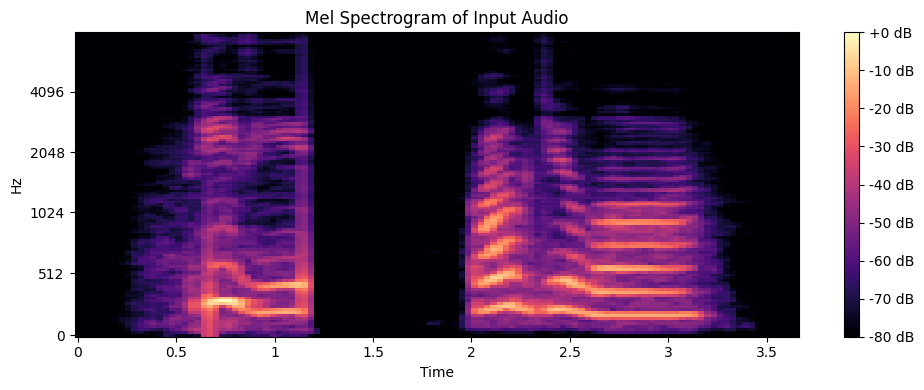

{'request_id': '482e40b9-c165-4502-921c-1cf6a1f904b6', 'source': 'audio', 'emotion_raw': 'neu', 'emotion_final': 'neu_low_certainty', 'confidence': 0.42762815952301025, 'metadata': {'sample_rate': 16000, 'duration_sec': 3.6480625}}


In [25]:
pipeline = AudioEmotionPipeline()
result = pipeline.process("my_audio.wav", show_spec=True)
print(result)

[AudioPipeline] Loading audio emotion model...
[AudioPipeline] Model loaded.


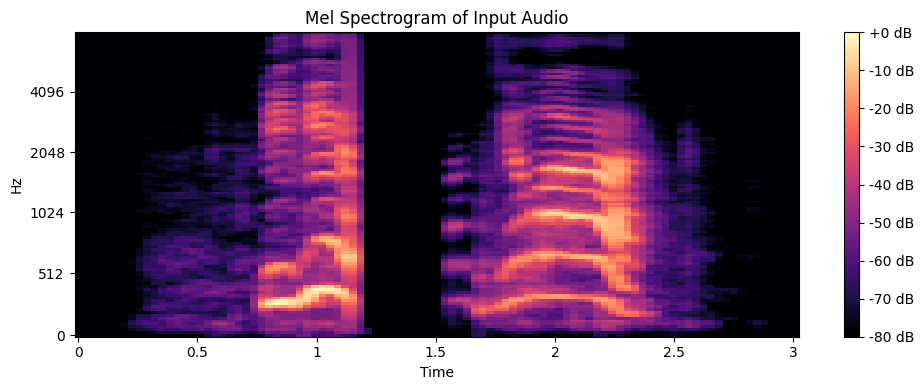

{'request_id': '418091e2-bab6-4d01-a53c-53241213713c', 'source': 'audio', 'emotion_raw': 'hap', 'emotion_final': 'hap', 'confidence': 0.7623785138130188, 'metadata': {'sample_rate': 16000, 'duration_sec': 3.0240625}}


In [26]:
pipeline = AudioEmotionPipeline()
result = pipeline.process("my_audio_happy.wav", show_spec=True)
print(result)

в принципе уверенность норм - подходит, дальше посмотрим может можнобудет улучшить. Работает на русском языке

In [27]:
pipeline = AudioEmotionPipeline()
result = pipeline.process("silents.wav", show_spec=True)
print(result)

[AudioPipeline] Loading audio emotion model...
[AudioPipeline] Model loaded.
{'error': 'Audio too quiet', 'emotion': None, 'confidence': None}


я тут молчала

___________________________________________________________________________________________

смотрим датасет спотифай

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d yamaerenay/spotify-dataset-1921-2020-160k-tracks

Dataset URL: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-1921-2020-160k-tracks
License(s): Community Data License Agreement - Sharing - Version 1.0
  0% 0.00/16.5M [00:00<?, ?B/s]
100% 16.5M/16.5M [00:00<00:00, 1.70GB/s]


In [7]:
!unzip spotify-dataset-1921-2020-160k-tracks.zip -d spotify160k

Archive:  spotify-dataset-1921-2020-160k-tracks.zip
  inflating: spotify160k/data.csv    
  inflating: spotify160k/data_by_artist.csv  
  inflating: spotify160k/data_by_genres.csv  
  inflating: spotify160k/data_by_year.csv  
  inflating: spotify160k/data_w_genres.csv  


In [9]:
import pandas as pd

tracks = pd.read_csv("spotify160k/data_w_genres.csv")

print(tracks.head())
print(tracks.columns)

           genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210

In [10]:
tracks.info()
tracks.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901,0.759170,13.847211
std,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552,0.427595,53.372544
min,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110362,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000,1.000000,2.000000
50%,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000,1.000000,3.000000
75%,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000,1.000000,8.000000
max,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000,1.000000,3169.000000


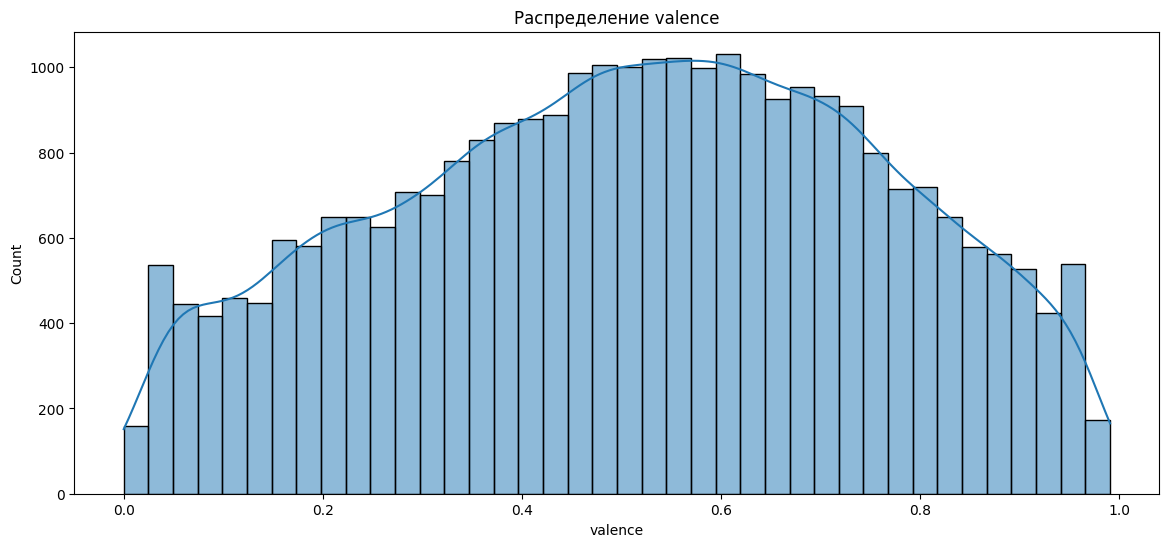

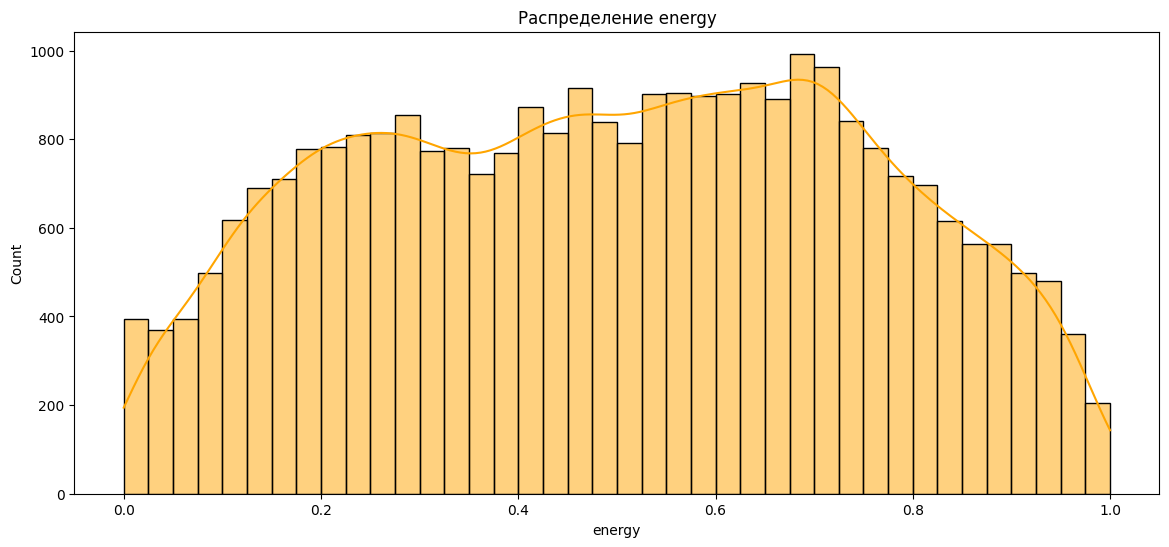

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.histplot(tracks['valence'], bins=40, kde=True)
plt.title("Распределение valence")
plt.show()

plt.figure(figsize=(14,6))
sns.histplot(tracks['energy'], bins=40, kde=True, color='orange')
plt.title("Распределение energy")
plt.show()

Valence

Распределение довольно равномерное, но больше всего треков находится в диапазоне 0.4–0.7.
Это значит, что в датасете много музыки со средним или слегка позитивным настроением, а совсем “грустных” и очень “весёлых” треков меньше.

Energy

У большинства треков энергия находится в диапазоне 0.4–0.8.
То есть в датасете больше умеренно энергичной и энергичной музыки, а совсем спокойных треков относительно мало.

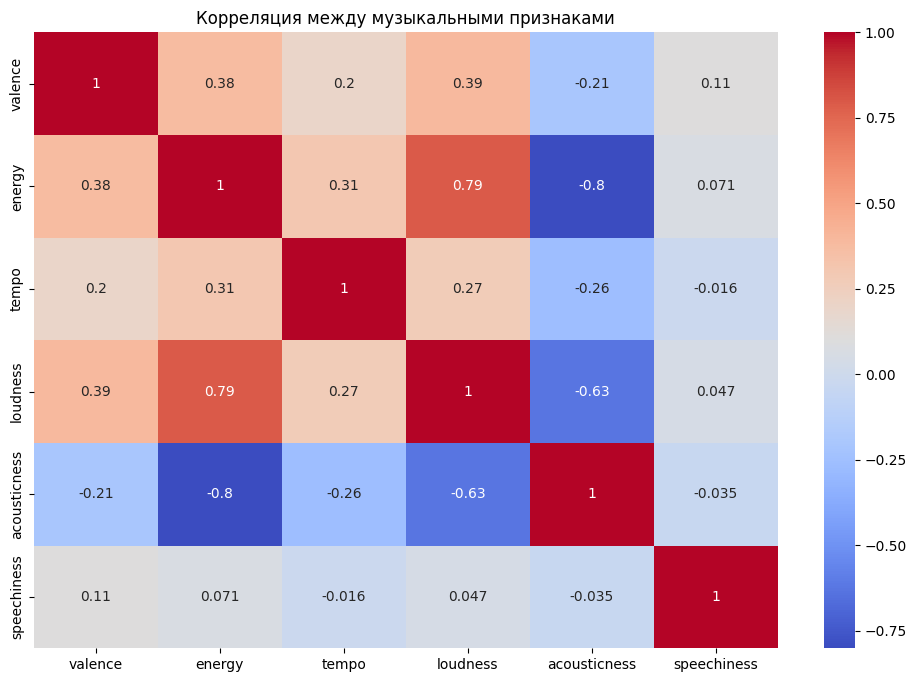

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(tracks[['valence','energy','tempo','loudness','acousticness','speechiness']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Корреляция между музыкальными признаками")
plt.show()

1. Energy и loudness

У них высокая положительная корреляция (0.79).
чем громче трек, тем он обычно энергичнее.

2. Energy и acousticness

Сильная отрицательная связь (–0.80).
Акустическая музыка чаще спокойная

3. Valence и loudness / energy

Valence слегка положительно связана с energy (0.38) и loudness (0.39).
То есть более “весёлые” треки чаще звучат громче и энергичнее.

4. Tempo почти ни с чем не связан

Связи слабые (~0.2–0.3).
Темп не сильно влияет на настроение.

5. Speechiness ни на что особо не влияет

Почти везде около нуля — показатель сам по себе слабый.

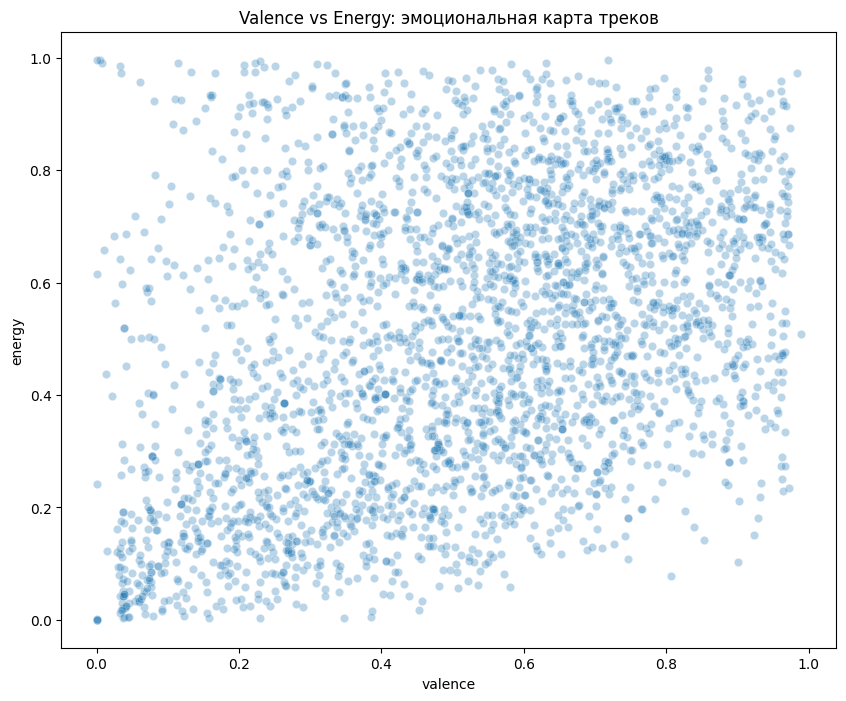

In [14]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=tracks.sample(3000), x='valence', y='energy', alpha=0.3)
plt.title("Valence vs Energy: эмоциональная карта треков")
plt.show()

Треки распределены достаточно равномерно

In [15]:
import ast

def parse_genres(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

tracks['genres_list'] = tracks['genres'].apply(parse_genres)

from collections import Counter

genre_counts = Counter([g for lst in tracks['genres_list'] for g in lst])
pd.DataFrame(genre_counts.most_common(20), columns=['genre','count'])

,genre,count
0,rock,611
1,pop,593
2,dance pop,572
3,rap,516
4,hip hop,507
5,pop rap,482
6,modern rock,400
7,pop rock,400
8,country rock,394
9,urban contemporary,383
